In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

***Task Overview***

As a researcher, I would like to find out the impact from contentious parameters ('market.stake.target.scalingFactor'), so that I can set a reasonable default value for them.

`market.stake.target.scalingFactor` is a market parameter defining scaling between liquidity demand estimate based on open interest and target stake. Its used in calculating of `target_stake' as below:

`target_stake = reference_price x max_oi x market.stake.target.scalingFactor x rf`,

- If the LPs total committed stake is less than c_1 x `target_stake` we trigger liquidity auction.
- `target_stake' is also used as a threshold in LP commitment amendment (when 'total stake' is less than `target_stake', then LP can not reduce their commitment amount), however we only need to focus on the function above at this stage. 
- Change of 'market.stake.target.scalingFactor' will immediately change the scaling between liquidity demand estimate based on open interest and target stake, hence immediately change the target satke, and therefore change the timing of triggering liquidity auction. 

***Input Metrics***

- simulated market is **ETH/USD** with market decimal place **mdp = 3**, asset decimal place **adp = 5** and position decimal place **pdp = 2**

- initial mid-price of **ETH/USD** is **$1123.11** (the average price on 15/06/2022)

- run **Trials=5** trials for each test

- each trial has **Time = 86400 s = 24 h** with interval of **5 min**

- target simulated daily traded notional is **$694,928,100.62**

- LP commitment is set to be a reasonable constant number in the simulation to avoid liquidity auction

- network parameter `market.stake.target.scalingFactor` is set to be [0.5, 5, 50]

***Output Metrics***
Under different network parameter `market.stake.target.scalingFactor`:

- Output 1: LP postion

- Output 2: average of LP margin account

- Output 3: average of LP bond account

- Output 4: average of LP's **general PnL** 

- Output 5: average of **traded notional**

- Output 6: average of market **open interest**

- Output 7: average of **target stake** of market 


### Call functions and display

In [2]:
data_target_05 = pd.read_csv("NETP_market.stake.target.scalingFactor_0.5.csv")
data_target_5 = pd.read_csv("NETP_market.stake.target.scalingFactor_5.csv")
data_target_50 = pd.read_csv("NETP_market.stake.target.scalingFactor_50.csv")

# If run multiple simulations
if not (data_target_5['Iteration'] == 0).all():
    trials = data_target_5['Iteration'].iloc[-1]
    ave_target_05 = data_target_05.groupby(data_target_05["Time Step"]).mean()
    ave_target_5 = data_target_5.groupby(data_target_5["Time Step"]).mean()
    ave_target_50 = data_target_50.groupby(data_target_50["Time Step"]).mean()

else:
    ave_target_05 = data_target_05.set_index(data_target_05['Time Step'])
    ave_target_5 = data_target_5.set_index(data_target_5['Time Step'])
    ave_target_50 = data_target_50.set_index(data_target_50['Time Step'])

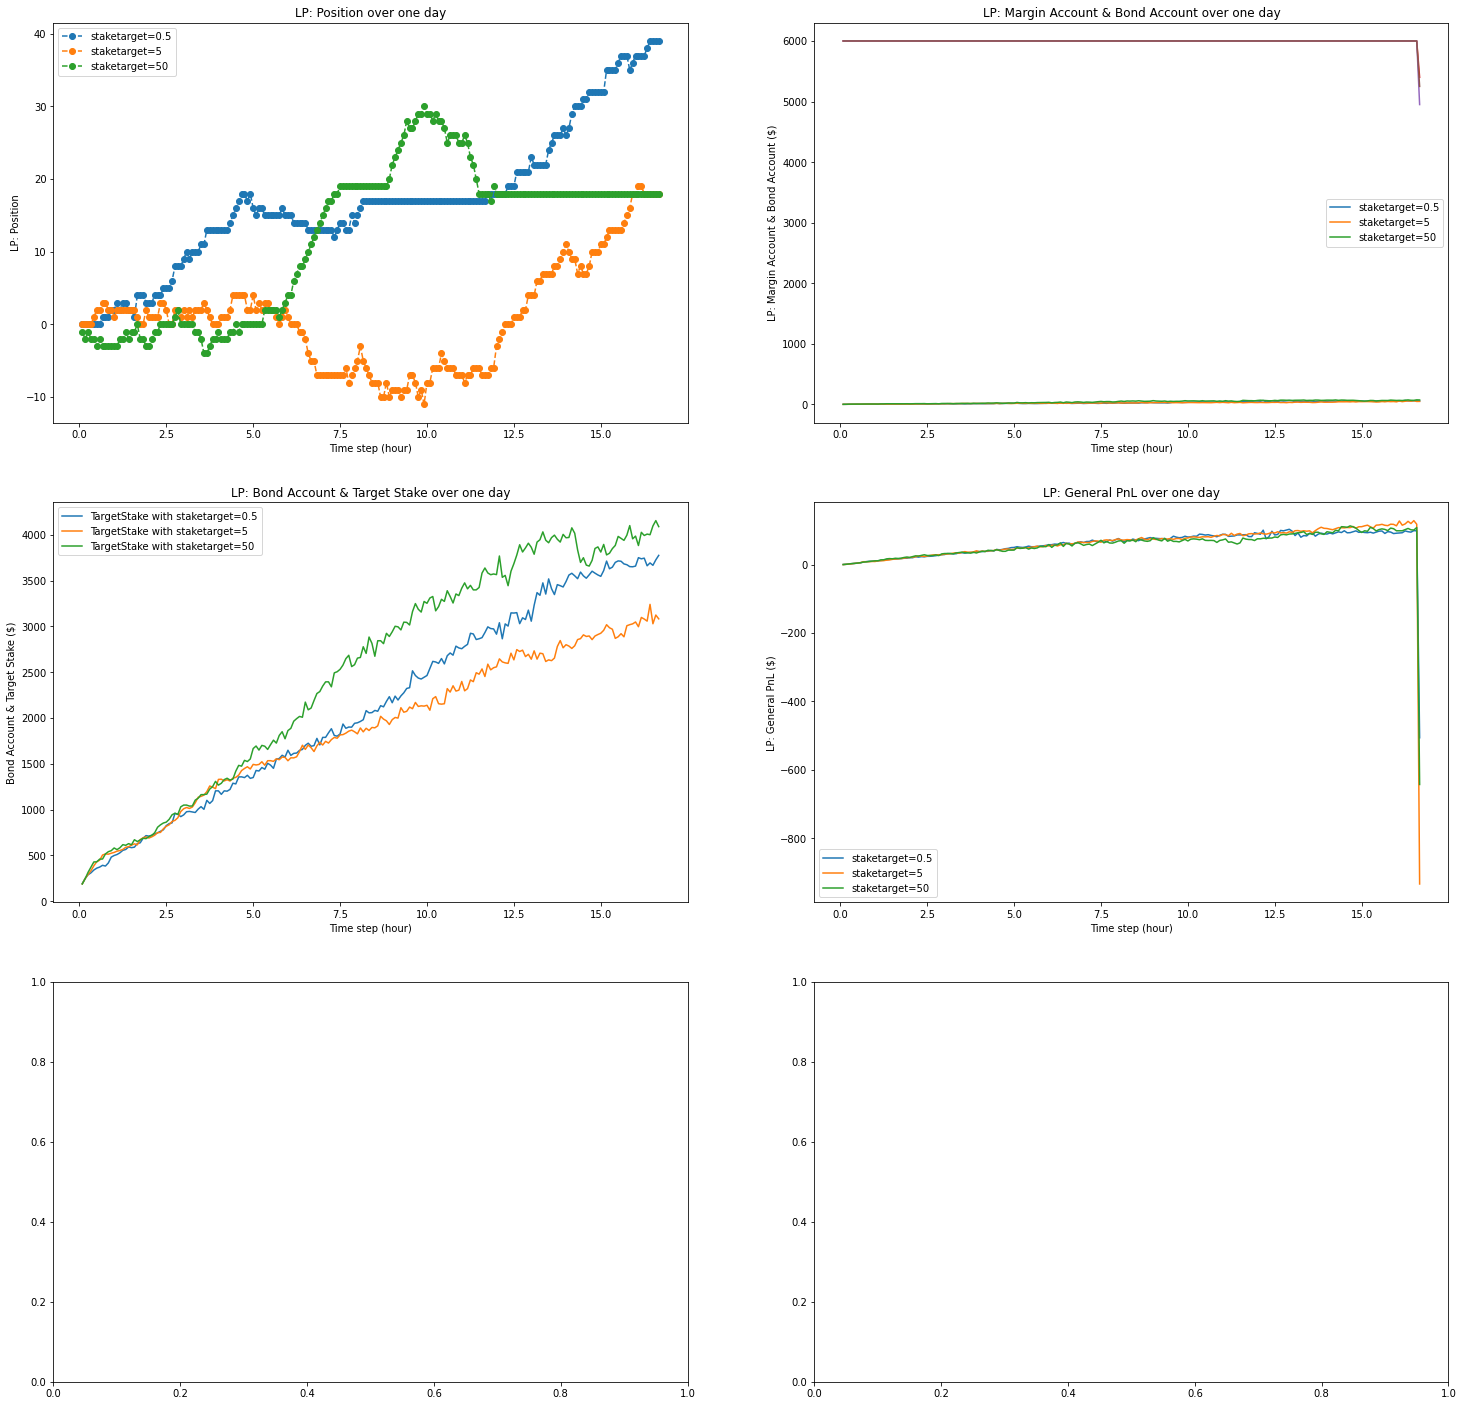

In [5]:
# Plot the optimal strategy
fig,ax = plt.subplots(3,2,figsize=(25,25))

dt = 5 / 60

# Plot LP: Position over time
ax[0,0].plot(ave_target_05.index * dt,data_target_05[data_target_05['Iteration'] == 1].iloc[:-1]['LP: Position'],'o--',label="staketarget=0.5")
ax[0,0].plot(ave_target_5.index * dt,data_target_5[data_target_5['Iteration'] == 1].iloc[:-1]['LP: Position'],'o--',label="staketarget=5")
ax[0,0].plot(ave_target_50.index * dt,data_target_50[data_target_50['Iteration'] == 1].iloc[:-1]['LP: Position'],'o--',label="staketarget=50")
# ax[0,0].plot(ave_tau_1.index * dt,data_tau_1['LP: Position'],'o--',label="tauscaling=1")
# ax[0,0].plot(ave_tau_10.index * dt,data_tau_10['LP: Position'],'o--',label="tauscaling=10")
# ax[0,0].plot(ave_tau_20.index * dt,data_tau_20['LP: Position'],'o--',label="tauscaling=20")
ax[0,0].set_title('LP: Position over one day')
ax[0,0].set_xlabel("Time step (hour)")
ax[0,0].set_ylabel("LP: Position")
ax[0,0].legend()

# Plot LP: Margin Account & Bond Account
ax[0,1].plot(ave_target_05.index * dt,ave_target_05['LP: Margin Account'],label="staketarget=0.5")
ax[0,1].plot(ave_target_5.index * dt,ave_target_5['LP: Margin Account'],label="staketarget=5")
ax[0,1].plot(ave_target_50.index * dt,ave_target_50['LP: Margin Account'],label="staketarget=50")
ax[0,1].plot(ave_target_05.index * dt,ave_target_05['LP: Bond Account'])
ax[0,1].plot(ave_target_5.index * dt,ave_target_5['LP: Bond Account'])
ax[0,1].plot(ave_target_50.index * dt,ave_target_50['LP: Bond Account'])
ax[0,1].set_title('LP: Margin Account & Bond Account over one day')
ax[0,1].set_xlabel("Time step (hour)")
ax[0,1].set_ylabel("LP: Margin Account & Bond Account ($)")
ax[0,1].legend()

# Plot LP: Bond Account with target stake in market
#ax[1,0].plot(ave_target_05.index * dt,ave_target_05['LP: Bond Account'],label="staketarget=0.5")
ax[1,0].plot(ave_target_05.index * dt,ave_target_05['Target Stake'],label="TargetStake with staketarget=0.5")
#ax[1,0].plot(ave_target_5.index * dt,ave_target_5['LP: Bond Account'],label="staketarget=5")
ax[1,0].plot(ave_target_5.index * dt,ave_target_5['Target Stake'],label="TargetStake with staketarget=5")
#ax[1,0].plot(ave_target_50.index * dt,ave_target_50['LP: Bond Account'],label="staketarget=50")
ax[1,0].plot(ave_target_50.index * dt,ave_target_50['Target Stake'],label="TargetStake with staketarget=50")
ax[1,0].set_title('LP: Bond Account & Target Stake over one day')
ax[1,0].set_xlabel("Time step (hour)")
ax[1,0].set_ylabel("Bond Account & Target Stake ($)")
ax[1,0].legend()

# Plot LP: General PnL
ax[1,1].plot(ave_target_05.index * dt,ave_target_05['LP: General Pnl'],label="staketarget=0.5")
ax[1,1].plot(ave_target_5.index * dt,ave_target_5['LP: General Pnl'],label="staketarget=5")
ax[1,1].plot(ave_target_50.index * dt,ave_target_50['LP: General Pnl'],label="staketarget=50")
ax[1,1].set_title('LP: General PnL over one day')
ax[1,1].set_xlabel("Time step (hour)")
ax[1,1].set_ylabel("LP: General PnL ($)")
ax[1,1].legend()

# # Plot Market Open Interest
# ax[2,0].plot(ave_target_05.index * dt,ave_target_05['Market Open Interest'],label="staketarget=0.5")
# ax[2,0].plot(ave_target_5.index * dt,ave_target_5['Market Open Interest'],label="staketarget=5")
# ax[2,0].plot(ave_target_50.index * dt,ave_target_50['Market Open Interest'],label="staketarget=50")
# ax[2,0].set_title('Market Open Interest over one day')
# ax[2,0].set_xlabel("Time step (hour)")
# ax[2,0].set_ylabel("Open Interest")
# ax[2,0].legend()

# # Plot Total Traded Notional
# ax[2,1].plot(ave_target_05.index * dt,ave_target_05['Total Traded Notional'],label="staketarget=0.5")
# ax[2,1].plot(ave_target_5.index * dt,ave_target_5['Total Traded Notional'],label="staketarget=5")
# ax[2,1].plot(ave_target_50.index * dt,ave_target_50['Total Traded Notional'],label="staketarget=50")
# ax[2,1].set_title('Total Traded Notional over one day')
# ax[2,1].set_xlabel("Time step (hour)")
# ax[2,1].set_ylabel("Traded Notional ($)")
# ax[2,1].legend()

plt.show()
